<a href="https://colab.research.google.com/github/VenkatMargapuri/SeedPhenotyping/blob/main/MaskRCNN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mask R-CNN instance segmentation with custom dataset in Google Colab
Jupyter notebook providing steps to train a **Matterport Mask R-CNN** model with custom dataset.

It runs in [Google Colab](https://colab.research.google.com/) using [Matterport framework](https://github.com/matterport/Mask_RCNN) with TensorFlow backend.

**Requirements are only dataset images and annotations file.**

**Colab Runtime type: Python3, GPU enabled.**

#Making Dataset
I generated dataset annotations with [VGG Image Annotator](http://www.robots.ox.ac.uk/~vgg/software/via/).

Notebook train a model for one class object detection. It is possible to slightly modify notebook to train model for multiple classes.

Before running notebook, we need to create dataset:


1.   Collect various pictures of objects to detect
3.   Create annotation files in VGG
4.   Create image.zip file having structure defined below
5.   Upload the zip file in your Google Drive

Zip file structure:
```
images.zip
|- "train" directory
  |- jpg image files of training data
  |- "via_region_data.json" annotations file of training data
|- "val" directory
  |- jpg image files of validation data
  |- "via_region_data.json" annotations file of validation data
```
Check my image.zip file as dataset example.

#Install required packages

In [ ]:
# Clone matterport's git repo
%cd
!git clone --quiet https://github.com/matterport/Mask_RCNN.git

/root
^C


In [ ]:
#Mount google drive for the trained model to be loaded
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# Unzip the zipped folder containing seeds
!unzip '/content/drive/My Drive/dataset/val.zip' -d '/content/drive/My Drive/dataset/RoughRiceSeeds1000'

In [ ]:
# Install the requirements for Mask R-CNN
%cd /content/drive/My Drive/Mask_RCNN-Trained
!pip install -q PyDrive
!pip install -r requirements.txt
!python setup.py install

#Download and extract dataset
Update fileId variable with Google Drive id of your image.zip dataset


#Edit settings file
*  find and replace occurrences of "balloon" and "Balloon" with name of your object
*  set epochs number


In [ ]:
#Create a new file from the existing file. We don't use dog.py since that is what the earlier implementation used.
%cd /content/drive/My Drive/Mask_RCNN-Trained

!cp '/content/drive/My Drive/Mask_RCNN-Trained/dog.py' ./syntheticdataset.py

# !sed -i -- 's/balloon/dog/g' dog.py
# !sed -i -- 's/Balloon/Dog/g' dog.py
# !sed -i -- 's/epochs=30/epochs=5/g' dog.py

/content/drive/My Drive/Mask_RCNN-Trained


#Train model
Pretrained weights options are COCO, ImageNet or a model trained before

In [ ]:
#%cd ~/Mask_RCNN-Trained
# Train the model with a weight of choice
!python syntheticdataset.py train --dataset=dataset/ --weights='imagenet'

#Run inference on test dataset

In [ ]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import syntheticdataset

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

#custom_WEIGHTS_PATH = sorted(glob.glob("/content/drive/My Drive/Mask_RCNN-Trained/logs/*/mask_rcnn_*.h5"))[-2]
CUSTOM_WEIGHTS_PATH = "/content/drive/MyDrive/Mask_RCNN-Trained/logs/AllSeedsDatasetWeights-R101-CC/mask_rcnn_object_0029.h5"

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join("/content/drive/My Drive/Mask_RCNN-Trained/", "logs")

config = syntheticdataset.CustomConfig()
#custom_DIR = os.path.join("/content/drive/My Drive/", "dataset/RoughRiceSeeds")

class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 6
    MAX_GT_INSTANCES = 600
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 80% confidence
    DETECTION_MIN_CONFIDENCE = 0.2

        # All of our training images are 768x768
    #IMAGE_MIN_DIM = 768
    #IMAGE_MAX_DIM = 768

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    #VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet101'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (2, 4, 8, 16, 32)
    RPN_ANCHOR_RATIOS = [1.5, 2, 3]
    TRAIN_ROIS_PER_IMAGE = 1200
    MAX_GT_INSTANCES = 600 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    RPN_TRAIN_ANCHORS_PER_IMAGE = 2000
    DETECTION_MAX_INSTANCES = 600


config = InferenceConfig()
#config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
  
# Load validation dataset
dataset = syntheticdataset.CocoLikeDataset()
dataset.load_data("/content/drive/MyDrive/dataset/AllSeedsDataset2-Test2/coco_instances.json", "/content/drive/MyDrive/dataset/AllSeedsDataset2-Test2/images")

#Must call before using the dataset
dataset.prepare()

#print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# Must call before using the dataset
#dataset.prepare()

#print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# Create model in inference mode
with tf.device(DEVICE):
    #config.NUM_CLASSES = 3
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", CUSTOM_WEIGHTS_PATH)
#model.load_weights(CUSTOM_WEIGHTS_PATH, by_name=True)
#model.keras_model.save('SoyModel.h5')
# Convert the model.
#converter = tf.lite.TFLiteConverter.from_keras_model_file('/content/drive/My Drive/Mask_RCNN-Trained/SoyModel.h5')
#tflite_model = converter.convert()


from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)

Loading weights  /content/drive/MyDrive/Mask_RCNN-Trained/logs/AllSeedsDatasetWeights-R101-CC/mask_rcnn_object_0029.h5


<module 'mrcnn.visualize' from '/content/drive/My Drive/Mask_RCNN-Trained/mrcnn/visualize.py'>

In [ ]:
# Also running inference but without using the methods from the synthetic dataset class.
# This method of running inference is faster
import skimage
import tensorflow as tf
from tensorflow import keras

rois = []
masks = []
classids = []
score_vals = []
dim = (768, 768)
real_test_dir = '/content/drive/MyDrive/dataset/WheatCoins/Wheat-Dime'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    rois.append(r['rois'])
    masks.append(r['masks'])
    classids.append(r['class_ids'])
    score_vals.append(r['scores'])
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                ['BG', 'canola', 'roughrice', 'wheat', 'sorghum', 'soy'], r['scores'], figsize=(8,8))

In [ ]:
# Code to start training the model with the train method implemented here.
# It makes it easier to kick off training here without having to open up multiple files in the viewer.
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import syntheticdataset
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = syntheticdataset.CocoLikeDataset()
    dataset_train.load_data("/content/drive/MyDrive/dataset/AllSeeds-Dataset2/coco_instances.json", "/content/drive/MyDrive/dataset/AllSeeds-Dataset2/images")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = syntheticdataset.CocoLikeDataset()
    dataset_train.load_data("/content/drive/MyDrive/dataset/AllSeeds-Dataset2-Test/coco_instances.json", "/content/drive/MyDrive/dataset/AllSeeds-Dataset2-Test/images")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=55,
                layers='heads')
    
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR,
                              config=config)
    
custom_WEIGHTS_PATH = os.path.join("/content/drive/My Drive/Mask_RCNN-Trained", "mask_rcnn_coco.h5")    
# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE,
#             epochs=25, 
#             layers="heads")
train(model)

In [ ]:
#image_id = random.choice(dataset.image_ids)
# trainModel.train()
# Code to kick off inference on a set of weights and compute IOUs and Recall
CUSTOM_WEIGHTS_PATH1 = "/content/drive/MyDrive/Mask_RCNN-Trained/logs/AllSeedsDatasetWeights-R101-CC/mask_rcnn_object_0029.h5"
CUSTOM_WEIGHTS_PATH2 = "/content/drive/MyDrive/Mask_RCNN-Trained/logs/AllSeedsDataset-R50-CC/mask_rcnn_object_0027.h5"

print(config.BACKBONE)
# # # Create model object in inference mode.
#print(MODEL_DIR)
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
#model2 = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# # # Load weights trained on MS-COCO
model.load_weights(CUSTOM_WEIGHTS_PATH1, by_name=True)
#model2.load_weights(CUSTOM_WEIGHTS_PATH2, by_name=True)

rois = []
masks = []
classids = []
score_vals = []
iou = 0.1

count = 0

print(len(dataset.image_ids))

for image_id in dataset.image_ids:
  image, image_meta, gt_class_id, gt_bbox, gt_mask =\
  modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
  info = dataset.image_info[image_id]
  print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                        dataset.image_reference(image_id)))

  # Run object detection
  results = model.detect([image], verbose=1)

  # Display results
  ax = get_ax(1)
  r = results[0]
  rois.append(r['rois'])
  masks.append(r['masks'])
  classids.append(r['class_ids'])
  score_vals.append(r['scores'])
  count += 1

  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                             ['BG', 'canola', 'roughrice', 'wheat', 'sorghum', 'soy'], r['scores'], ax=ax,
                             title="Predictions")
  
  recall = utils.compute_recall(r["rois"],gt_bbox,iou)[0]
  AP, _,_,_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                     r['rois'], r['class_ids'], r['scores'], r['masks'],iou_threshold = iou)
    
  log("gt_class_id", gt_class_id)
  for i in r['class_ids']:
    print(i)
  log("gt_bbox", gt_bbox)
  log("gt_mask", gt_mask)
  print("image:",image_id)
  print("recall:", recall)
  print("mask AP50:", AP)


(768, 768, 73)
604.0
634.5
682.5
579.5
664.0
548.0
515.0
579.5
577.5
666.0
660.0
542.0
622.0
592.0
567.5
657.0
565.0
441.5
622.0
671.0
593.5
554.5
425.5
603.0
556.5
661.5
492.0
683.0
412.5
644.0
550.5
571.0
497.5
506.0
412.5
542.5
632.5
615.5
639.5
592.0
562.0
451.0
641.0
604.5
467.5
642.0
505.5
666.0
455.0
599.0
383.0
522.0
637.5
504.5
521.5
554.5
599.0
656.5
245.0
654.0
517.5
676.0
558.5
658.0
628.5
647.0
525.5
666.5
556.0
455.5
659.0
508.0
636.0


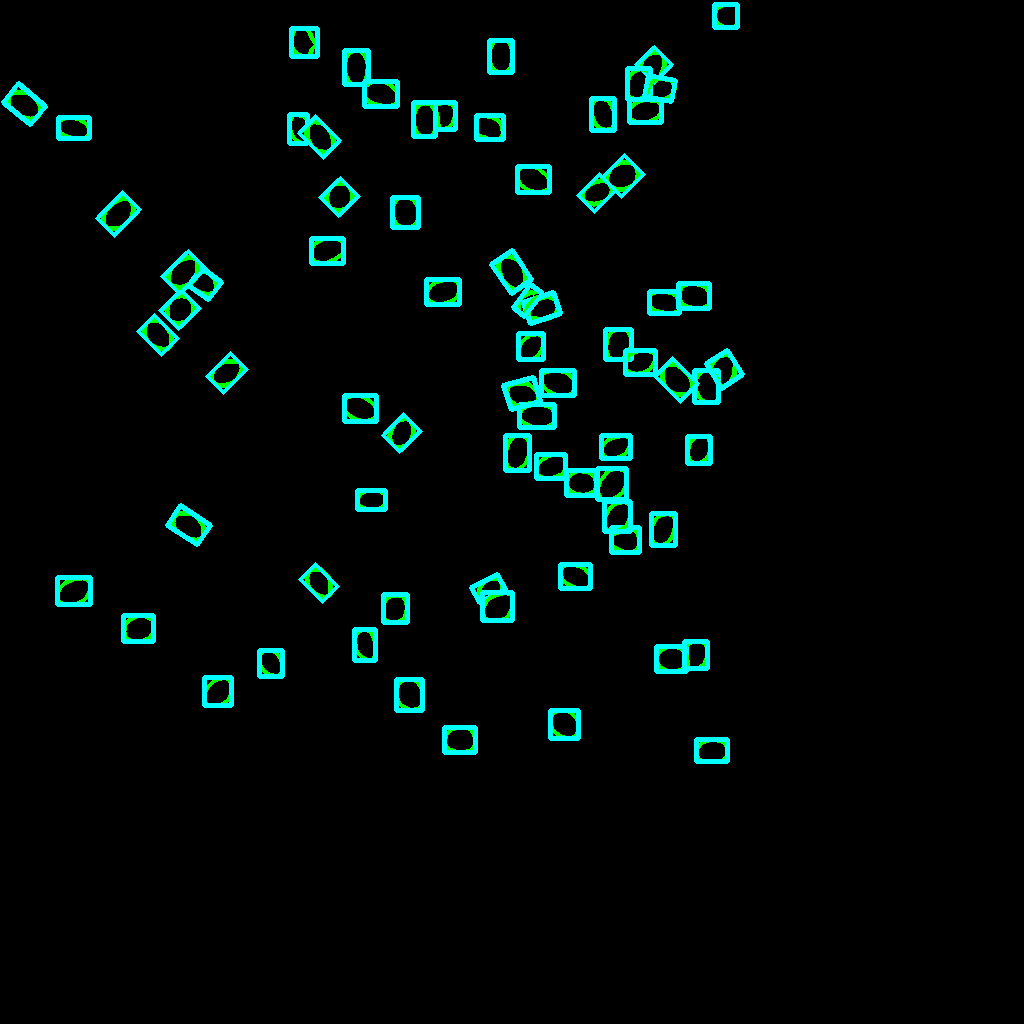

59


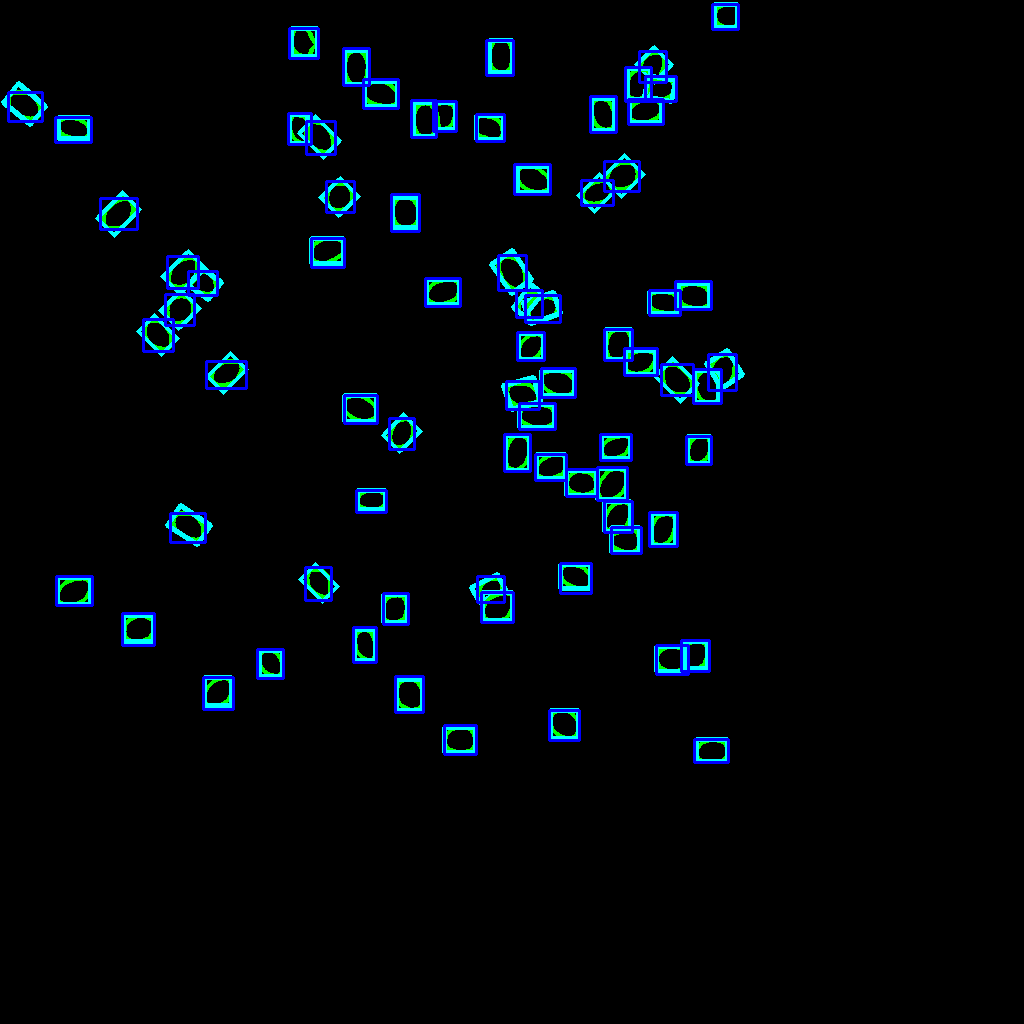

In [ ]:
# Estimation of bounding rectangles to compute the area.
from google.colab.patches import cv2_imshow # for image display

#size = (w, h, channels) = (1024, 1024, 15)
size = (w, h) = (1024, 1024)

color = (255, 0, 0) 
thickness = 2

img1 = np.zeros(size, np.uint8)
finalImg = np.zeros((1024, 1024, 3), np.uint8)
cnt = 0

#print(masks)

singleMask = masks[8]
print(np.shape(singleMask))

maskContours = []
for k in range(len(singleMask[0][0])):
  for i in range(len(singleMask)):
    for j in range(len(singleMask[0])):
        if(singleMask[i][j][k] == False):
          img1[i][j] = 0
        else:
          img1[i][j] = 255
    
  contours, hierarchy = cv2.findContours(np.asmatrix(img1),  
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cv2.drawContours(finalImg, contours, -1, (0, 255, 0),3)


  rotatedRect = cv2.minAreaRect(contours[0])
  box = cv2.boxPoints(rotatedRect)
  box = np.int0(box)
  cv2.drawContours(finalImg, [box], -1, (255, 255, 0),3)
  print(cv2.contourArea(contours[0]))

cv2_imshow(finalImg) 


print(len(rois[0]))
cnt = 0
for i, v in enumerate(rois[8]):
    cv2.rectangle(finalImg, (v[1], v[0]), (v[3], v[2]), color, thickness)

cv2_imshow(finalImg)





In [ ]:
img[0][0][0] = 255  #convert to an unsigned byte
indices*=255
cv2_imshow(img)
cv2.waitKey()